<a href="https://colab.research.google.com/github/emicervantes/wound_classification/blob/main/wound_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

### Load Wound Data

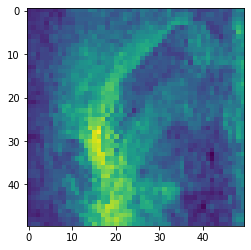

In [2]:
X = np.load('wound_features.npy', encoding = 'bytes')
Y = np.load('wound_label.npy', encoding = 'bytes')
XTr, XTe, YTr, YTe = train_test_split(X,Y,test_size = 0.30)

plt.imshow(XTr[3,:,:,0])

In [3]:
batch_size = 100

torch_XTr = torch.tensor(XTr)
torch_YTr = torch.tensor(YTr)
torch_XTe = torch.tensor(XTe)
torch_YTe = torch.tensor(YTe)

train = torch.utils.data.TensorDataset(torch_XTr, torch_YTr)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

test = torch.utils.data.TensorDataset(torch_XTe, torch_YTe)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [4]:
X, Y = next(iter(train_loader))
print(X.shape, Y.shape)

torch.Size([100, 50, 50, 3]) torch.Size([100])


In [16]:
num_epochs = 50
num_classes = 6
batch_size = 100
learning_rate = 1e-5
input_size = 7500
hidden_size = 100

In [11]:
X = X.reshape(-1,3*50*50)

### MLP

In [28]:
class NeuralNet(nn.Module):
  def __init__(self, input_size = 7500, hidden_size = 100, num_classes = 6):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()

    self.fc2 = nn.Linear(hidden_size, 200)
    self.fc3 = nn.Linear(200, num_classes)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    return out


In [27]:
X

tensor([[176, 199, 221,  ...,  15,  24,  28],
        [189, 192, 253,  ..., 156, 184, 245],
        [ 93, 113, 151,  ..., 119, 155, 200],
        ...,
        [121, 140, 207,  ..., 152, 170, 235],
        [ 97, 124, 174,  ...,  25,  33,  46],
        [141, 166, 247,  ..., 120, 170, 252]], dtype=torch.uint8)

In [30]:
model = NeuralNet(input_size, hidden_size, num_classes)
output = model(X.float())

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [42]:

# Train the model
total_step = len(train_loader)
#num_epochs = 5
model.train()
for epoch in range(num_epochs):    
    for i, (X, Y) in enumerate(train_loader):

        X = X.reshape(-1,3*50*50)
        # Forward pass       
        outputs = model(X.float())   

        # Calculate Loss     
        loss = criterion(outputs, Y)

        # Backward and optimize   
        optimizer.zero_grad()     
        loss.backward()
        optimizer.step()       

        #store loss and iteration
        
        if (i+1) % 6 == 0:
            #print('Iteration: {} Loss: {} '.format(count, loss.item()))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                  .format(epoch+1, num_epochs, (i+1), total_step, loss.item()))

        #Total Iterations (if use the right # in count % # == 0) which equal 
        #total_step * epochs

Epoch [1/50], Step [6/6], Loss: 0.5164
Epoch [2/50], Step [6/6], Loss: 0.2316
Epoch [3/50], Step [6/6], Loss: 0.2638
Epoch [4/50], Step [6/6], Loss: 0.4690
Epoch [5/50], Step [6/6], Loss: 0.3500
Epoch [6/50], Step [6/6], Loss: 0.3916
Epoch [7/50], Step [6/6], Loss: 0.2839
Epoch [8/50], Step [6/6], Loss: 0.5231
Epoch [9/50], Step [6/6], Loss: 0.3342
Epoch [10/50], Step [6/6], Loss: 0.3572
Epoch [11/50], Step [6/6], Loss: 0.5562
Epoch [12/50], Step [6/6], Loss: 0.1845
Epoch [13/50], Step [6/6], Loss: 0.3015
Epoch [14/50], Step [6/6], Loss: 0.4035
Epoch [15/50], Step [6/6], Loss: 0.3014
Epoch [16/50], Step [6/6], Loss: 0.3793
Epoch [17/50], Step [6/6], Loss: 0.6705
Epoch [18/50], Step [6/6], Loss: 0.4123
Epoch [19/50], Step [6/6], Loss: 0.3952
Epoch [20/50], Step [6/6], Loss: 0.3518
Epoch [21/50], Step [6/6], Loss: 0.6607
Epoch [22/50], Step [6/6], Loss: 0.3278
Epoch [23/50], Step [6/6], Loss: 0.2836
Epoch [24/50], Step [6/6], Loss: 0.2322
Epoch [25/50], Step [6/6], Loss: 0.3720
Epoch [26

In [44]:
#Test the model
model.eval()
testmod_acc = []
with torch.no_grad():    
    for X, Y in test_loader:
        X = X.reshape(-1,3*50*50)
        outputs = model(X.float())
        _, predicted = torch.max(outputs.data, 1)
        testmod_acc.append((predicted == Y).sum().item() / predicted.size(0))
        

    print('Test Accuracy of the model = {} %'.format(100*np.mean(testmod_acc)))


Test Accuracy of the model = 48.15151515151515 %


### LSTM